In [7]:
import os, sys
import numpy as np
import torch
from data_loader import *
from preprocess.acf import *
from preprocess.gaussianize import *
import matplotlib.pyplot as plt
from model import *
from copy import deepcopy
from scipy.stats import wasserstein_distance
from scipy.stats import kurtosis
from hurst import compute_Hc
from arch import arch_model
import yaml
import joblib

# COSCI-GAN 디렉토리로 이동
path = '/workspace/COSCI-GAN_Journal'
try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory {0} does not exist".format(path))
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)

Current working directory: /workspace/COSCI-GAN_Journal


In [8]:
# Results 폴더에서 생성할 모델 이름 불러오기
full_name = 'LSTM_LSTM_MLP_400_64_gamma_5.0_Glr_0.0001_Dlr_0.0001_CDlr_1e-05_seqlen_36_loss_BCE'
G_type = 'LSTM'       # 생성자 모델 타입
num_epochs = 200      # 학습한 epoch 수
n_groups = 4          # 학습한 자산 수
asset_idx = 0

# Load necessary models and data
def load_data(asset_idx):
    standardScaler1 = joblib.load(f'./Dataset/pickle/{asset_idx}_standardScaler1.pkl')
    standardScaler2 = joblib.load(f'./Dataset/pickle/{asset_idx}_standardScaler2.pkl')
    gaussianize = joblib.load(f'./Dataset/pickle/{asset_idx}_gaussianize.pkl')
    log_returns = joblib.load(f'./Dataset/pickle/{asset_idx}_log_returns.pkl')
    return standardScaler1, standardScaler2, gaussianize, log_returns

In [9]:
generator = {}
window = 20    # {1, 5, 20, 100} days
noise = torch.randn(100, 3, 127)

## 실제값과 생성값의 {window=1, 5, 20, 100} days distribution의 차이를 기준으로 가장 좋은 epoch을 찾음
best_epochs = 0
min_emd = 0
min_distance = float('inf')    
for asset_epoch in range(0, num_epochs, 2):        
    if G_type == 'LSTM':            
        generator_tmp = LSTMGenerator(3, 1)
        generator_temp_dict = torch.load(f'./Results/{full_name}/Generator_{asset_idx}_{asset_epoch}.pt')            
        new_generator_temp_dict = deepcopy(generator_temp_dict)             
        for key in generator_temp_dict.keys():
            new_generator_temp_dict[key[7:]] = new_generator_temp_dict.pop(key)
        generator_tmp.load_state_dict(new_generator_temp_dict)                   
                                    
    y = generator_tmp(noise).cpu().detach().squeeze()                
    y = (y - y.mean(axis=0))/y.std(axis=0)
    standardScaler1, standardScaler2, gaussianize, log_returns = load_data(asset_idx)
    y = standardScaler2.inverse_transform(y)
    y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
    y = standardScaler1.inverse_transform(y)
    if y.size == 0:            
        continue
            
    real_dist = rolling_window(log_returns, window, sparse = not (window == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, window, sparse = not (window == 1)).sum(axis=0).ravel()
    
    emd = wasserstein_distance(real_dist, fake_dist)    
    if emd < min_distance:
        min_distance = emd
        best_epochs = asset_epoch        
        min_emd = min_distance
        print(f"min_distance:{min_distance}, best_epochs:{asset_epoch}")

print()
print(f"best_epochs = {best_epochs}")
print(f"min_emd = {min_emd}")

for asset_idx in range(n_groups):
    generator[asset_idx] = LSTMGenerator(3, 1)
    generator_temp_dict = torch.load(f'./Results/{full_name}/Generator_{asset_idx}_{best_epochs}.pt')            
    new_generator_temp_dict = deepcopy(generator_temp_dict)             
    for key in generator_temp_dict.keys():
        new_generator_temp_dict[key[7:]] = new_generator_temp_dict.pop(key)
    generator[asset_idx].load_state_dict(new_generator_temp_dict)                       
    print(f"Generator_{asset_idx}_{best_epochs}.pt loaded")

min_distance:0.02362752755821125, best_epochs:0
min_distance:0.008941011108280049, best_epochs:46
min_distance:0.008006531861523199, best_epochs:50
min_distance:0.007435308926066144, best_epochs:52
min_distance:0.005297827043944307, best_epochs:62
min_distance:0.004283971739164903, best_epochs:64
min_distance:0.004132268681097143, best_epochs:150
min_distance:0.004027300079841279, best_epochs:152
min_distance:0.0036793860698630812, best_epochs:164

best_epochs = 164
min_emd = 0.0036793860698630812
Generator_0_164.pt loaded
Generator_1_164.pt loaded
Generator_2_164.pt loaded
Generator_3_164.pt loaded


In [11]:
######################## 
# 생성하고자 하는 인덱스 선택 #
########################
asset_num = 1000                           # 생성할 데이터의 개수
asset_length = 254                         # 생성할 데이터의 길이
noise = torch.randn(asset_num, 3, asset_length)

In [16]:
### 데이터 생성
fake_list = []
real_list = []
for i in range(0, n_groups):
    
    y = generator[i](noise).cpu().detach().squeeze()
    y = (y - y.mean(axis=0))/y.std(axis=0)
    standardScaler1, standardScaler2, gaussianize, log_returns = load_data(i)
    y = standardScaler2.inverse_transform(y)
    y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
    y = standardScaler1.inverse_transform(y)

    #some basic filtering to redue the tendency of GAN to produce extreme returns
    y = y[(y.max(axis=1) <= 2.0 * log_returns.max()) & (y.min(axis=1) >= 2.0 * log_returns.min())]
    print(y.shape)
    
    fake_list.append(y)
    real_list.append(log_returns)

# 합성 데이터 저장
joblib.dump(real_list, './real_list.pkl')
joblib.dump(fake_list, './fake_list.pkl')


(972, 254)
(993, 254)
(999, 254)
(999, 254)


['./fake_list.pkl']

(2562, 1)
(2562, 1)
(2562, 1)
(2562, 1)


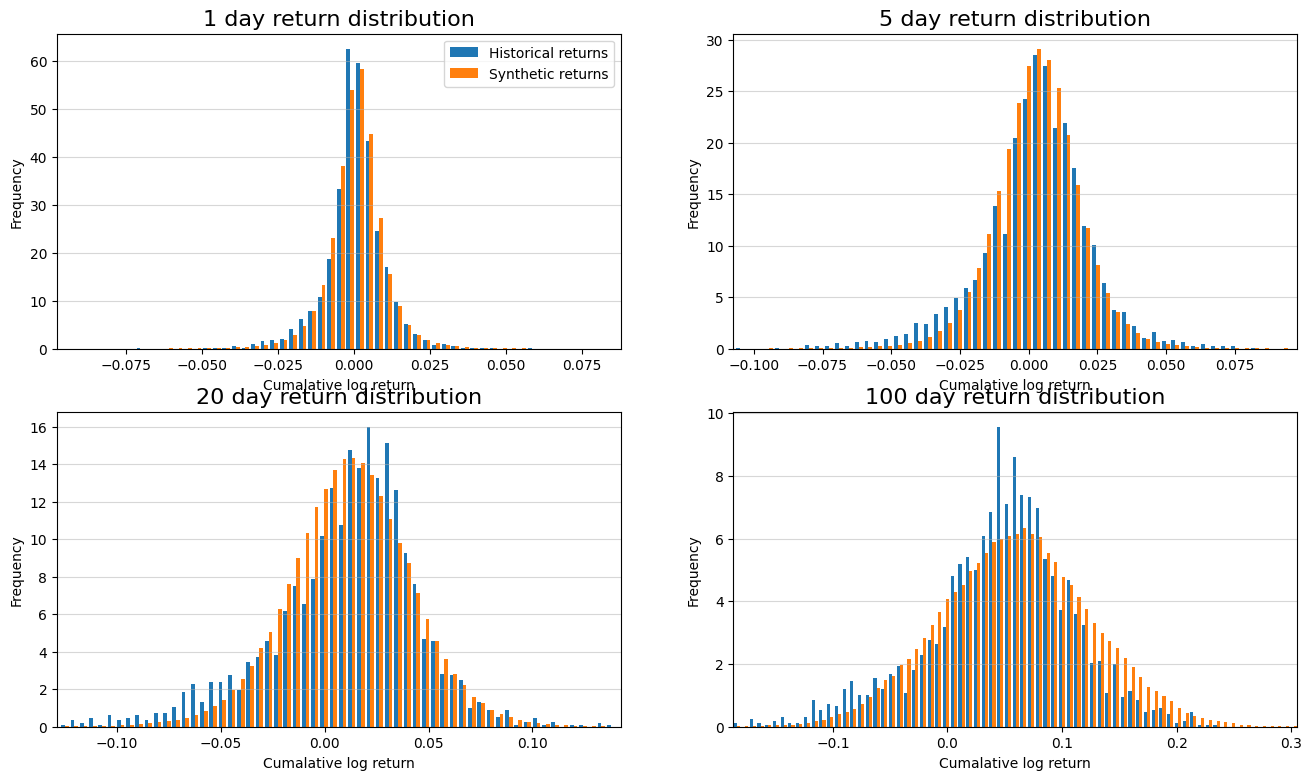

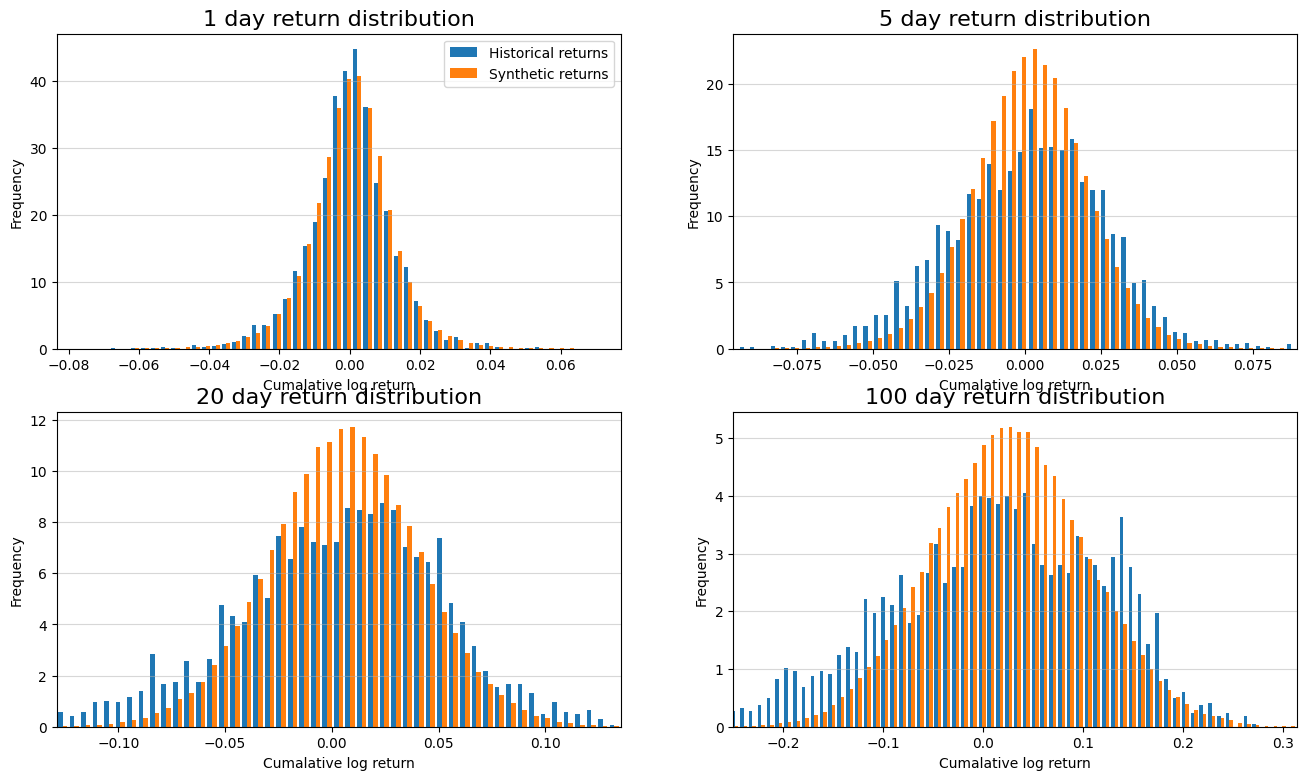

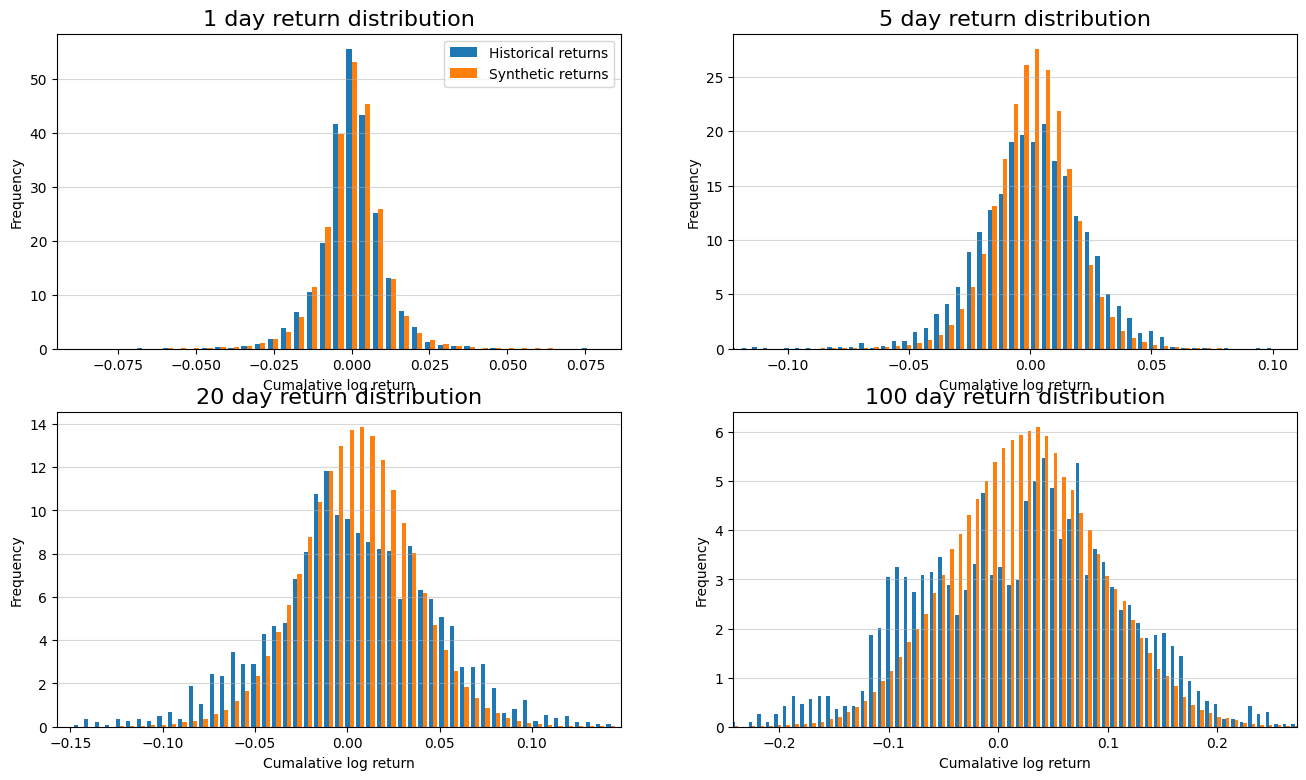

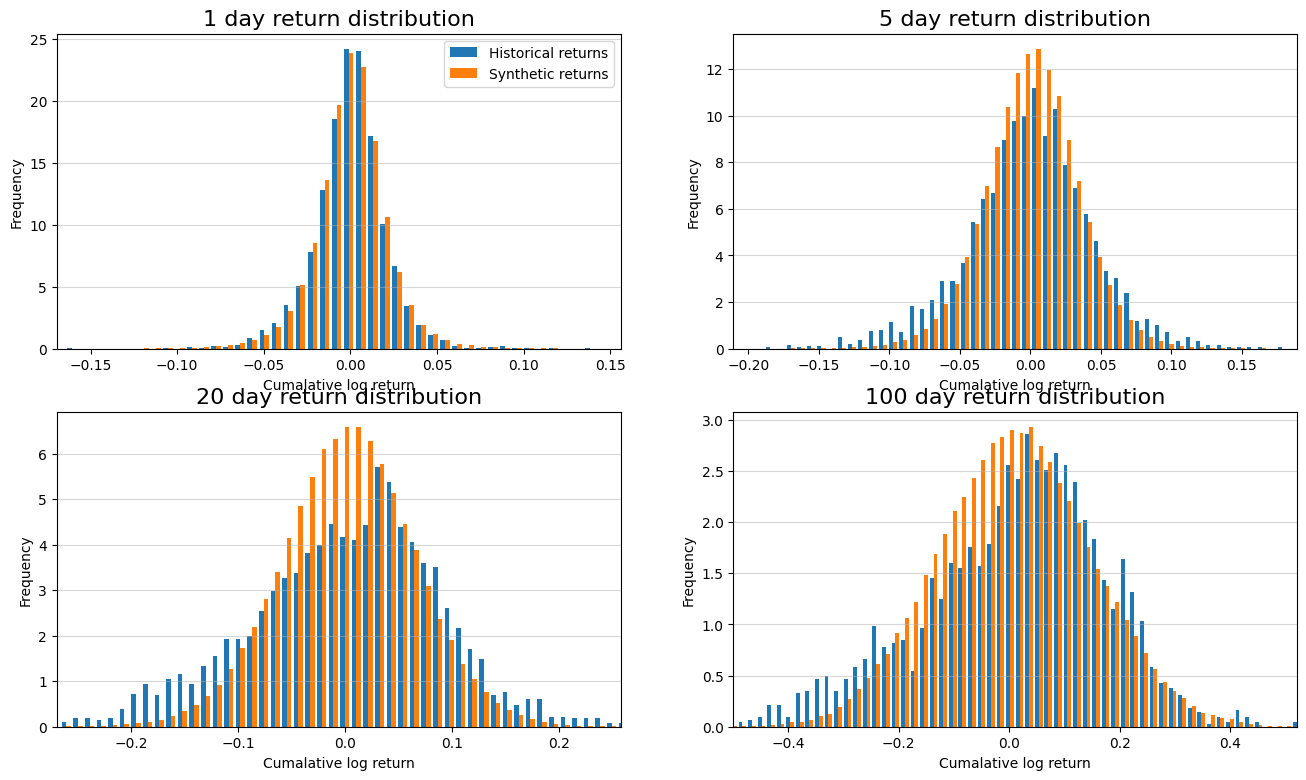

In [23]:
### Log Return Distribution
n_bins = 20
windows = [1, 5, 20, 100]
for j in range(n_groups):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))
    print(log_returns.shape)    

    for i in range(len(windows)):
        row = min(max(0, i-1), 1) 
        col = i % 2
        real_dist = rolling_window(real_list[j], windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
        fake_dist = rolling_window(fake_list[j].T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
        axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=80, density=True)
        axs[row,col].set_xlim(*np.quantile(fake_dist, [0.0001, .9999]))
        
        axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
        axs[row,col].yaxis.grid(True, alpha=0.5)
        axs[row,col].set_xlabel('Cumalative log return')
        axs[row,col].set_ylabel('Frequency')

    axs[0,0].legend(['Historical returns', 'Synthetic returns'])

In [24]:
# Correlation Analysis of synthetic data
df_all = []        
for i in range(n_groups):
    
    y = generator[i](noise).cpu().detach().squeeze()
    y = (y - y.mean(axis=0))/y.std(axis=0)
    y = standardScaler2.inverse_transform(y)
    standardScaler1, standardScaler2, gaussianize, log_returns = load_data(i)
    y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
    y = standardScaler1.inverse_transform(y)
    
    df = pd.DataFrame(y)
    df = df[(y.max(axis=1) <= 2.0 * y.max()) & (y.min(axis=1) >= 2.0 * y.min())]
    df_all.append(df)
    
df_merge = pd.concat(df_all, axis=1)
df_merge.dropna(axis=0, inplace=True)

corr_list1 = []
corr_list2 = []
corr_list3 = []
corr_list4 = []
corr_list5 = []
corr_list6 = []
for index, row in df_merge.iterrows():
    df1 = row[0:asset_length]
    df2 = row[asset_length:asset_length*2]
    df3 = row[asset_length*2:asset_length*3]
    df4 = row[asset_length*3:asset_length*4]
    df_final = pd.DataFrame({'Asset1':df1, 'Asset2':df2, 'Asset3':df3, 'Asset4':df4})
    corr_matrix = df_final.corr()
    corr1_corr2 = corr_matrix.loc['Asset1', 'Asset2']
    corr1_corr3 = corr_matrix.loc['Asset1', 'Asset3']
    corr1_corr4 = corr_matrix.loc['Asset1', 'Asset4']
    corr2_corr3 = corr_matrix.loc['Asset2', 'Asset3']
    corr2_corr4 = corr_matrix.loc['Asset2', 'Asset4']
    corr3_corr4 = corr_matrix.loc['Asset3', 'Asset4']
    corr_list1.append(corr1_corr2)
    corr_list2.append(corr1_corr3)
    corr_list3.append(corr1_corr4)
    corr_list4.append(corr2_corr3)
    corr_list5.append(corr2_corr4)
    corr_list6.append(corr3_corr4)

df_1 = pd.DataFrame(corr_list1, columns=['corr1-corr2'])
df_2 = pd.DataFrame(corr_list2, columns=['corr1-corr3'])
df_3 = pd.DataFrame(corr_list3, columns=['corr1-corr4'])
df_4 = pd.DataFrame(corr_list4, columns=['corr2-corr3'])
df_5 = pd.DataFrame(corr_list5, columns=['corr2-corr4'])
df_6 = pd.DataFrame(corr_list6, columns=['corr3-corr4'])

corr_df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6], axis=1)
avg_corr = corr_df.mean()
var_corr = corr_df.std()

print('\nMean of synthetic data correlation')
print(avg_corr)
print()
print('Standard Deviation of synthetic data correlation')
print(var_corr)



Mean of synthetic data correlation
corr1-corr2    0.967269
corr1-corr3    0.998424
corr1-corr4    0.979609
corr2-corr3    0.979829
corr2-corr4    0.998495
corr3-corr4    0.989263
dtype: float64

Standard Deviation of synthetic data correlation
corr1-corr2    0.024817
corr1-corr3    0.001136
corr1-corr4    0.015545
corr2-corr3    0.015822
corr2-corr4    0.001195
corr3-corr4    0.008502
dtype: float64


In [15]:
# correlation Analysis of real data
with open('./Dataset/indices.csv', 'rb') as fh:
    df = pd.read_csv(fh)
date = pd.to_datetime(df.iloc[1:, 0], format='%Y-%m-%d')
df = df.iloc[:, 1:].apply(pd.to_numeric).astype(float)
df_log_return = np.log(df / df.shift(1))[1:]

print('correlation matrix of real data')
df_log_return.corr()

correlation matrix of real data


,S&P500,HANGSENG,GOLD,WTI_OIL
S&P500,1.000000,0.235909,0.029083,0.383681
HANGSENG,0.235909,1.000000,0.044555,0.185086
GOLD,0.029083,0.044555,1.000000,0.153808
WTI_OIL,0.383681,0.185086,0.153808,1.000000
